使用先前輸出的bank_handled，和使用SHAP來選用重要特徵

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
# os.chdir("/content/drive/MyDrive/大三/下學期/機器學習應用/Datasets/ Bank Marketing")
os.chdir("/content/drive/MyDrive/機器學習期末/Datasets")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering import
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder ,LabelEncoder ,OrdinalEncoder ,StandardScaler
from imblearn.over_sampling import SMOTE

# Model import
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier ,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier ,RandomForestRegressor
import xgboost as xgb
from xgboost import XGBClassifier ,XGBRegressor
from sklearn.svm import SVC ,SVR
from sklearn.neighbors import KNeighborsClassifier ,KNeighborsRegressor

# Evaluate import
from sklearn import metrics
from sklearn.metrics import accuracy_score ,precision_score ,recall_score ,f1_score ,roc_auc_score ,roc_curve ,classification_report ,confusion_matrix
from sklearn.metrics import r2_score ,mean_squared_error, mean_absolute_error ,explained_variance_score

# PipeLine use import
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# sns.set(style="whitegrid")
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 2)
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# Load Data

In [ ]:
df = pd.read_csv("./bank_handled.csv")

df # 45211 rows × 17 columns

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y,contact_cellular,contact_telephone
0,58,4.0,1.0,2.0,0.0,2143,1.0,0.0,5,8.0,261,1,-1,0,0,0.0,0.0
1,44,9.0,2.0,1.0,0.0,29,1.0,0.0,5,8.0,151,1,-1,0,0,0.0,0.0
2,33,2.0,1.0,1.0,0.0,2,1.0,1.0,5,8.0,76,1,-1,0,0,0.0,0.0
3,47,1.0,1.0,1.0,0.0,1506,1.0,0.0,5,8.0,92,1,-1,0,0,0.0,0.0
4,33,1.0,2.0,1.0,0.0,1,0.0,0.0,5,8.0,198,1,-1,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,9.0,1.0,2.0,0.0,825,0.0,0.0,17,9.0,977,3,-1,0,1,1.0,0.0
45207,71,5.0,0.0,0.0,0.0,1729,0.0,0.0,17,9.0,456,2,-1,0,1,1.0,0.0
45208,72,5.0,1.0,1.0,0.0,5715,0.0,0.0,17,9.0,1127,5,184,3,1,1.0,0.0
45209,57,1.0,1.0,1.0,0.0,668,0.0,0.0,17,9.0,508,4,-1,0,0,0.0,1.0


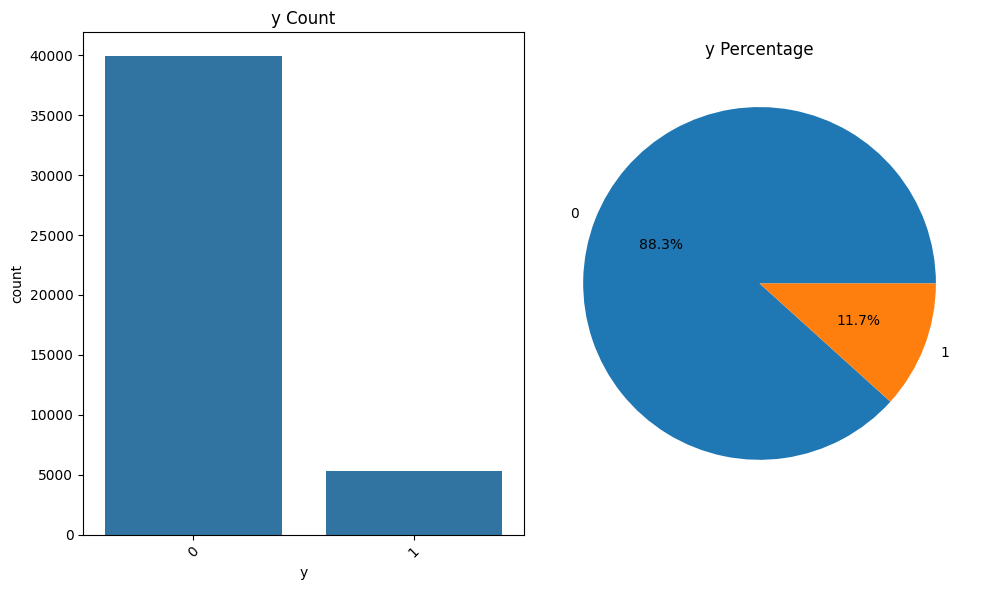

y
0    39922
1     5289
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1 ,2 ,1)
sns.countplot(data =df ,x ='y')
plt.xticks(rotation=45)
plt.title('y Count')

plt.subplot(1 ,2 ,2)
profile_counts = df['y'].value_counts()
plt.pie(profile_counts, labels = profile_counts.index, autopct='%1.1f%%')
plt.title('y Percentage')
plt.tight_layout()
plt.show()

print(df['y'].value_counts()) # No:39922(88.3%) ,Yes:5289(11.7%)

# Train Test Split
資料分割，將資料集拆分為訓練集和測試集，針對訓練集的數值特徵做標準化然後做異常值處理

In [ ]:
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
# print('='*30)
# # 查看全部資料的類別比例
# print(pd.Series(y).value_counts(normalize=True))
# # 查看訓練集標籤的分佈
# print(pd.Series(y_train).value_counts(normalize=True))
# # 查看測試集的標籤分佈
# print(pd.Series(y_test).value_counts(normalize=True))

X_train: (31647, 16)
X_test: (13564, 16)
y_train: (31647,)
y_test: (13564,)


In [ ]:
from collections import Counter

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 27956, 1: 3691})
Testing target statistics: Counter({0: 11966, 1: 1598})


In [ ]:
numeric_cols = X_train.select_dtypes(include=['int','float']).columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols]) # 在測試集上做相同的轉換

如果在測試集上使用fit_transform，那測試集會使用它自己的平均值和標準差進行轉換，這會導致訓練和測試的資料分布不一致

In [ ]:
def remove_outliers(df, cols, threshold=3):
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

X_train_no_outliers = remove_outliers(pd.DataFrame(X_train, columns=numeric_cols), numeric_cols)
y_train_no_outliers = y_train[X_train_no_outliers.index]

In [ ]:
print(f"Training target statistics: {Counter(y_train_no_outliers)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 23469, 1: 2639})
Testing target statistics: Counter({0: 11966, 1: 1598})


# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_no_outliers, y_train_no_outliers)

In [ ]:
X_resampled # 46938 rows × 16 columns

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,contact_cellular,contact_telephone
0,-4.65e-01,1.46,1.37,1.33,-0.14,-0.46,-1.12,-0.44,0.14,0.16,-0.40,0.39,-0.41,-0.24,-1.36,-0.26
1,1.42e+00,-0.70,-0.28,-0.21,-0.14,-0.39,-1.12,-0.44,0.38,1.16,0.21,0.07,-0.41,-0.24,0.74,-0.26
2,4.76e-01,-1.01,-0.28,-0.21,-0.14,-0.46,0.89,-0.44,-1.30,0.16,-0.67,-0.24,-0.41,-0.24,-1.36,-0.26
3,5.49e-03,-0.08,-1.93,1.33,-0.14,0.69,-1.12,-0.44,-1.78,1.49,0.17,-0.56,0.78,1.81,0.74,-0.26
4,-2.77e-01,-1.01,-0.28,-0.21,-0.14,-0.46,0.89,-0.44,0.50,0.82,-0.65,-0.56,-0.41,-0.24,-1.36,-0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46933,4.69e-01,-1.32,-0.28,-0.21,-0.14,-0.28,-1.12,-0.44,-1.13,-1.51,0.49,-0.39,-0.41,-0.24,0.74,-0.26
46934,3.70e-01,-0.08,1.37,1.33,-0.14,-0.36,0.89,-0.44,-0.74,-0.09,-0.62,-0.08,-0.41,-0.24,0.74,-0.26
46935,-3.28e-01,-0.08,1.37,1.33,-0.14,-0.20,0.89,-0.44,-1.48,1.00,1.66,0.20,1.33,2.43,0.74,-0.26
46936,-1.64e+00,1.32,1.37,-0.21,-0.14,-0.27,-1.12,-0.44,-0.63,0.04,1.91,-0.41,1.41,0.39,0.74,-0.26


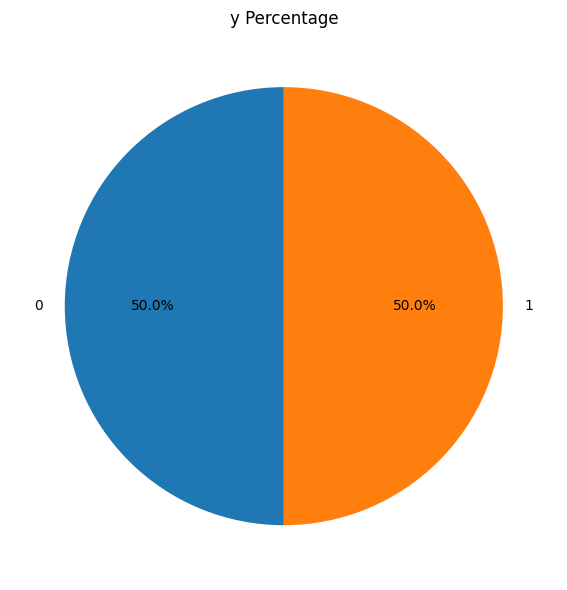

y
0    23469
1    23469
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(10, 6))

profile_counts = y_resampled.value_counts()
plt.pie(profile_counts, labels=profile_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('y Percentage')
plt.tight_layout()
plt.show()

print(y_resampled.value_counts()) # No:23469(50%) ,Yes:23469(50%)

# Feature Importance(RandomForestClassifier)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100 ,random_state=42)
rf_model.fit(X_resampled, y_resampled)

importances = rf_model.feature_importances_
feature_scores = pd.Series(importances, index=X_resampled.columns).sort_values(ascending=False)
feature_scores

duration             3.22e-01
campaign             1.05e-01
month                1.01e-01
balance              7.13e-02
day                  6.49e-02
age                  6.13e-02
contact_cellular     5.40e-02
pdays                4.61e-02
job                  4.28e-02
previous             4.25e-02
housing              4.07e-02
education            2.08e-02
marital              1.78e-02
loan                 9.46e-03
default              0.00e+00
contact_telephone    0.00e+00
dtype: float64

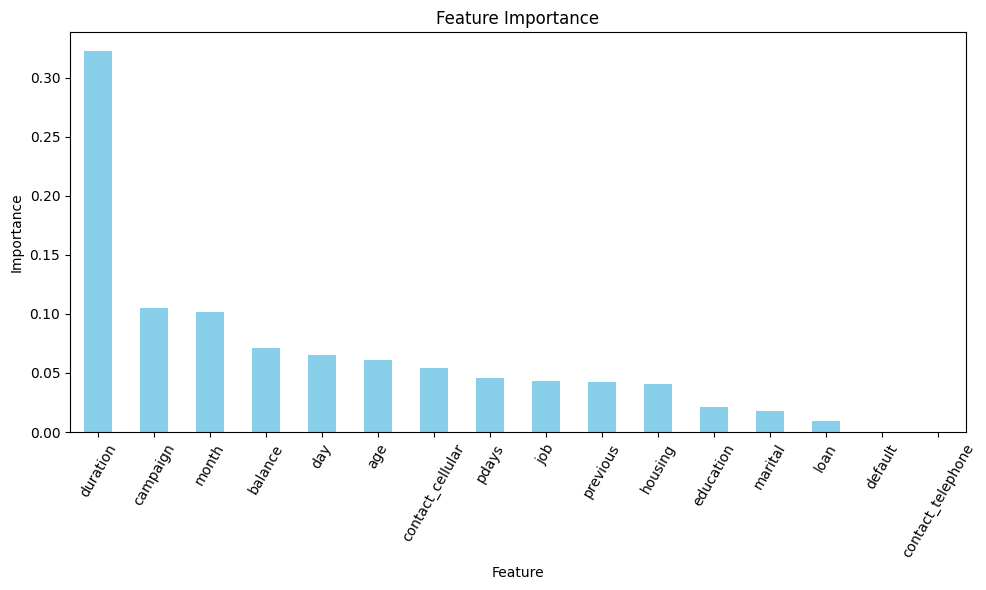

In [ ]:
plt.figure(figsize=(10, 6))
feature_scores.plot(kind='bar', color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

In [ ]:
# feature_scores = pd.Series(importances, index=X_resampled.columns).sort_values(ascending=False)
# top_50_percent_threshold = feature_scores.quantile(0.5)
# top_features = feature_scores[feature_scores >= top_50_percent_threshold].index

# X_resampled = X_resampled[top_features]
# X_test = X_test[top_features]
# print("Selected Features:")
# print(top_features)

# Feature Importance (xgboost)

In [ ]:
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_resampled, y_resampled)

importances = xgb_model.feature_importances_
feature_scores = pd.Series(importances, index=X_resampled.columns).sort_values(ascending=False)
feature_scores

contact_cellular     0.31
duration             0.13
campaign             0.12
housing              0.11
previous             0.07
month                0.07
loan                 0.04
job                  0.03
pdays                0.03
education            0.03
day                  0.02
balance              0.02
age                  0.02
marital              0.01
default              0.00
contact_telephone    0.00
dtype: float32

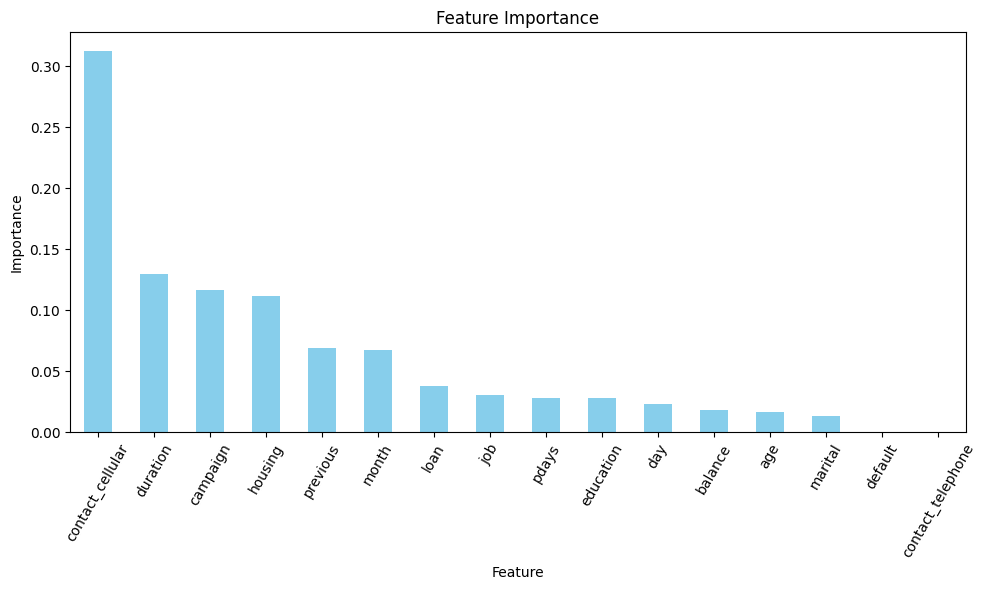

In [ ]:
plt.figure(figsize=(10, 6))
feature_scores.plot(kind='bar', color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

In [ ]:
# feature_scores = pd.Series(importances, index=X_resampled.columns).sort_values(ascending=False)
# top_50_percent_threshold = feature_scores.quantile(0.5)
# top_features = feature_scores[feature_scores >= top_50_percent_threshold].index

# X_resampled = X_resampled[top_features]
# X_test = X_test[top_features]
# print("Selected Features:")
# print(top_features)

# Shap

In [ ]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.6 MB/s eta 0:00:00


In [ ]:
import shap
# print the JS visualization code to the notebook
shap.plots.initjs()

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_resampled)

In [ ]:
print("X shape:", X_resampled.shape)
print("SHAP values shape:", shap_values.shape)

X shape: (46938, 16)
SHAP values shape: (46938, 16)


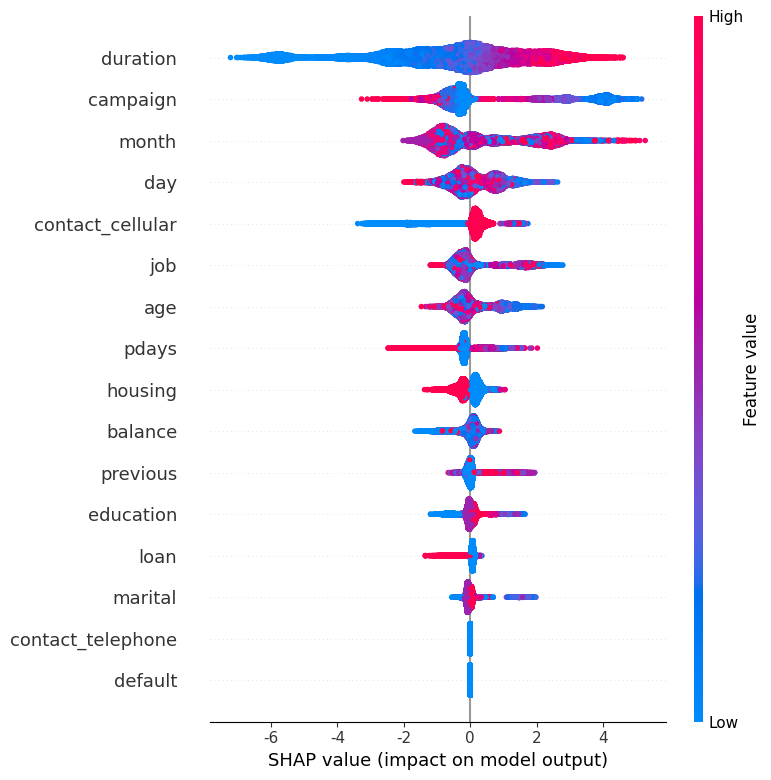

In [ ]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_resampled)

*   duration：這是最重要的特徵。高duration（紅色）增加了模型輸出，而低duration（藍色）則相反。
*   campaign：高campaign（紅色）通常對模型輸出有負面影響，低campaign（藍色）則有正面影響，顯示了負相關性。



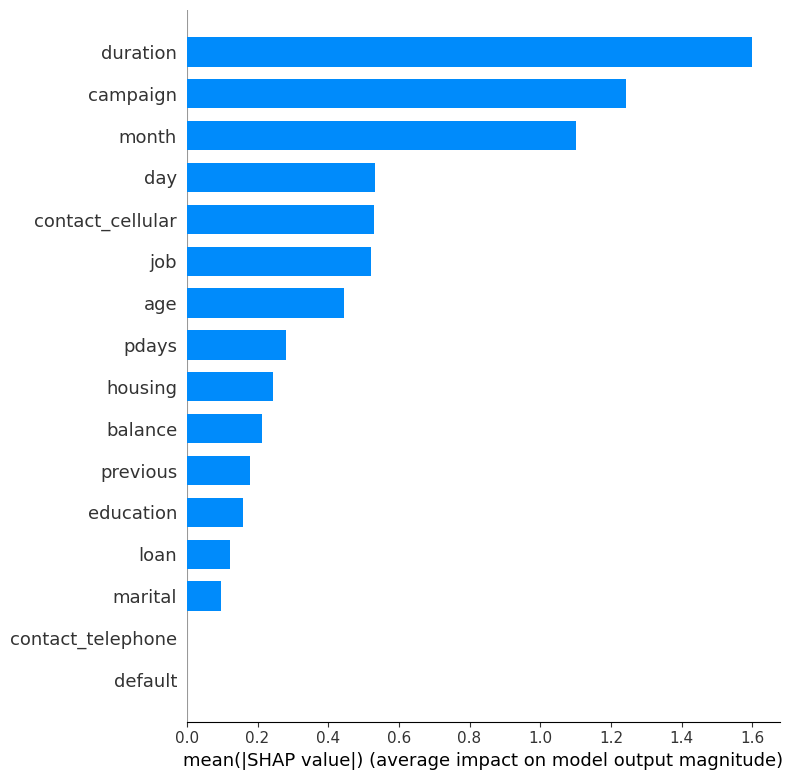

In [ ]:
# Bar chart of mean importance
shap.summary_plot(shap_values, X_resampled, plot_type="bar")

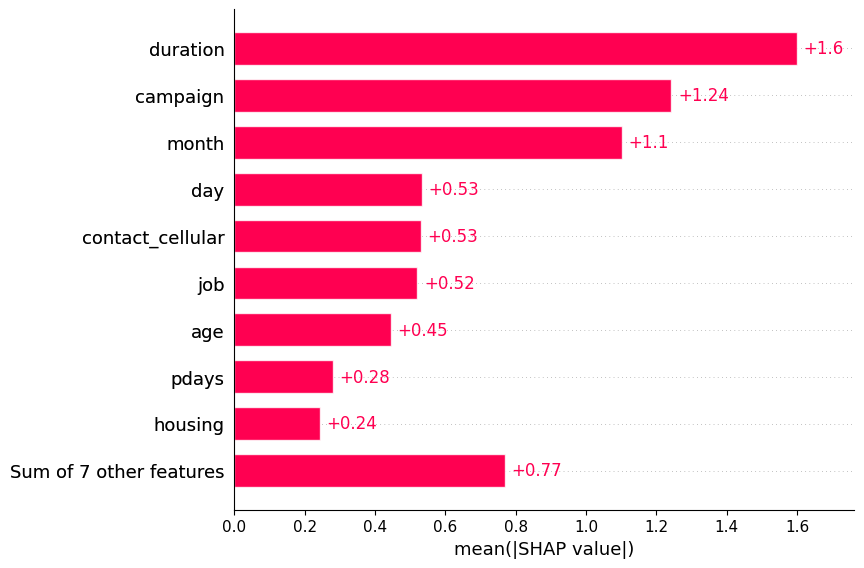

In [ ]:
# Global bar plot
shap.plots.bar(shap_values)

*   duration：這是對模型預測影響最大的特徵，平均SHAP值為1.6，表明該特徵對預測結果有重大貢獻。
*   campaign：這是第二重要的特徵，表明campaign對預測結果也有重要影響。



In [ ]:
use_columns = ['duration' ,'campaign' ,'month' ,'day' ,'contact_cellular' ,'job' ,'age' ,'pdays']

# 更新訓練集和測試集，只保留這些特徵
X_resampled = X_resampled[use_columns]
X_test = X_test[use_columns]

In [ ]:
X_resampled # 46938 rows × 8 columns

,duration,campaign,month,day,contact_cellular,job,age,pdays
0,-0.40,0.39,0.16,0.14,-1.36,1.46,-4.65e-01,-0.41
1,0.21,0.07,1.16,0.38,0.74,-0.70,1.42e+00,-0.41
2,-0.67,-0.24,0.16,-1.30,-1.36,-1.01,4.76e-01,-0.41
3,0.17,-0.56,1.49,-1.78,0.74,-0.08,5.49e-03,0.78
4,-0.65,-0.56,0.82,0.50,-1.36,-1.01,-2.77e-01,-0.41
...,...,...,...,...,...,...,...,...
46933,0.49,-0.39,-1.51,-1.13,0.74,-1.32,4.69e-01,-0.41
46934,-0.62,-0.08,-0.09,-0.74,0.74,-0.08,3.70e-01,-0.41
46935,1.66,0.20,1.00,-1.48,0.74,-0.08,-3.28e-01,1.33
46936,1.91,-0.41,0.04,-0.63,0.74,1.32,-1.64e+00,1.41


In [ ]:
X_test # 13564 rows × 8 columns

,duration,campaign,month,day,contact_cellular,job,age,pdays
3776,-0.25,-0.56,0.82,0.02,-1.36,-1.01,-8.86e-02,-0.41
9928,-0.67,-0.24,0.16,-0.82,-1.36,0.85,5.70e-01,-0.41
33409,-0.12,-0.56,-1.84,0.50,0.74,1.15,-1.50e+00,-0.41
31885,0.21,-0.56,-1.84,-0.82,0.74,-0.08,9.95e-02,2.94
15738,-0.53,-0.24,-0.17,0.62,0.74,-0.08,1.42e+00,-0.41
...,...,...,...,...,...,...,...,...
9016,-0.81,-0.56,0.16,-1.30,-1.36,1.46,4.76e-01,-0.41
380,-0.48,-0.56,0.82,-1.18,-1.36,-1.01,-2.77e-01,-0.41
7713,0.16,0.07,0.82,1.70,-1.36,-1.32,5.49e-03,-0.41
12188,-0.89,0.39,0.16,0.50,-1.36,1.15,5.49e-03,-0.41


# Model

In [ ]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Training Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     23469
           1       0.98      0.96      0.97     23469

    accuracy                           0.97     46938
   macro avg       0.97      0.97      0.97     46938
weighted avg       0.97      0.97      0.97     46938

AUC:
0.9703438578550428


Testing Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     11966
           1       0.59      0.53      0.56      1598

    accuracy                           0.90     13564
   macro avg       0.76      0.74      0.75     13564
weighted avg       0.90      0.90      0.90     13564

AUC:
0.7384882427620855


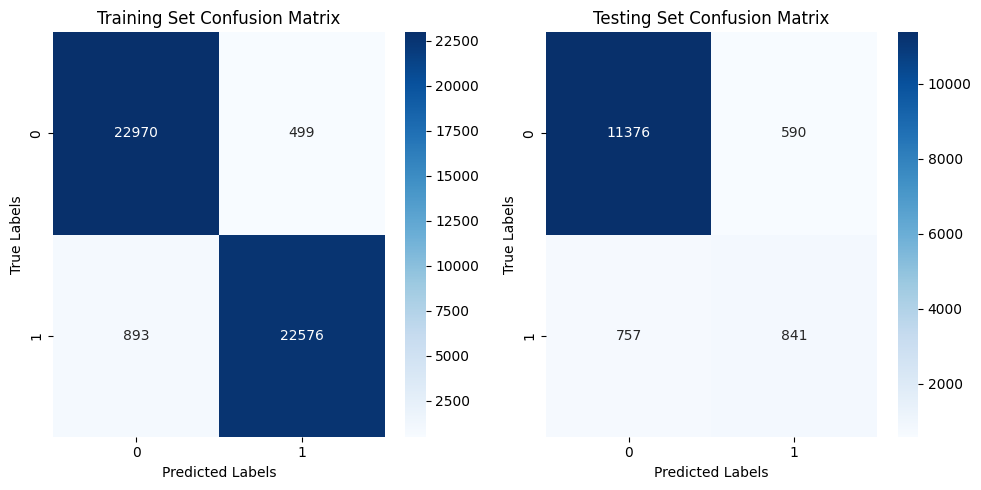

In [ ]:
def evaluate_model_performance(model, X_train, X_test, y_train, y_test):
    # 訓練集上的模型評分
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='binary')
    train_recall = recall_score(y_train, y_train_pred, average='binary')
    train_f1 = f1_score(y_train, y_train_pred, average='binary')
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_pred)
    print("Training Set Evaluation:")
    # print("Accuracy:", train_accuracy)
    # print("Precision:", train_precision)
    # print("Recall:", train_recall)
    # print("F1 Score:", train_f1)
    # print("Confusion Matrix:")
    # print(train_conf_matrix)
    print("Classification Report:")
    print(train_classification_report)
    print("AUC:")
    print(train_auc)
    print("\n")

    # 測試集上的模型評分
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='binary')
    test_recall = recall_score(y_test, y_test_pred, average='binary')
    test_f1 = f1_score(y_test, y_test_pred, average='binary')
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    print("Testing Set Evaluation:")
    # print("Accuracy:", test_accuracy)
    # print("Precision:", test_precision)
    # print("Recall:", test_recall)
    # print("F1 Score:", test_f1)
    # print("Confusion Matrix:")
    # print(test_conf_matrix)
    print("Classification Report:")
    print(test_classification_report)
    print("AUC:")
    print(test_auc)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Training Set Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.subplot(1, 2, 2)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Testing Set Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()
evaluate_model_performance(xgb_model, X_resampled, X_test, y_resampled, y_test)

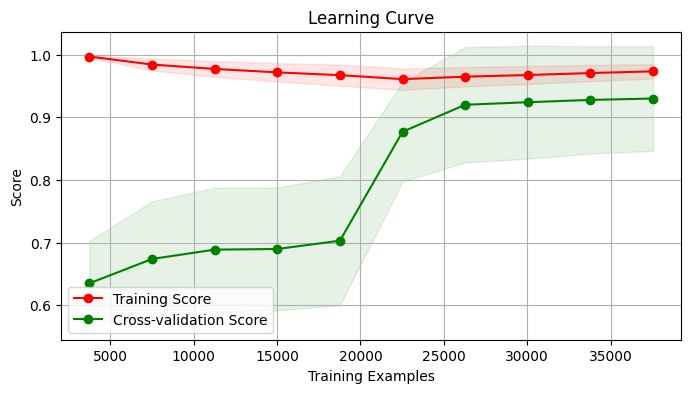

Train Sizes: [ 3755  7510 11265 15020 18775 22530 26285 30040 33795 37550]
Train Scores Mean: [0.99680426 0.9841012  0.97707945 0.97159787 0.96715846 0.96080781
 0.96471752 0.9673968  0.97050451 0.97328362]
Test Scores Mean: [0.6352223  0.67401771 0.68888813 0.68993229 0.70316328 0.87690323
 0.91996018 0.92400808 0.92767239 0.92986674]


In [ ]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1)
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 4))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
    plt.legend(loc="best")
    plt.show()

    # Print additional information
    print("Train Sizes:", train_sizes)
    print("Train Scores Mean:", train_scores_mean)
    print("Test Scores Mean:", test_scores_mean)
plot_learning_curve(xgb_model, X_resampled, y_resampled)

In [ ]:
def plot_roc_curves(pipelines, X_test, y_test):
    plt.figure()
    for name, pipeline in pipelines.items():
        # Predict probabilities
        if hasattr(pipeline, 'predict_proba'):
            y_probs = pipeline.predict_proba(X_test)[:, 1]
        else:
            y_probs = pipeline.decision_function(X_test)

        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = roc_auc_score(y_test, y_probs)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:0.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def plot_roc_curves(pipelines, X_test, y_test):
    plt.figure()
    for name, pipeline in pipelines.items():
        # Predict probabilities
        if hasattr(pipeline, 'predict_proba'):
            y_probs = pipeline.predict_proba(X_test)[:, 1]
        else:
            y_probs = pipeline.decision_function(X_test)

        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = roc_auc_score(y_test, y_probs)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:0.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

=====Evaluating XGBoost model..=====
Training Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     23469
           1       0.98      0.96      0.97     23469

    accuracy                           0.97     46938
   macro avg       0.97      0.97      0.97     46938
weighted avg       0.97      0.97      0.97     46938

AUC:
0.9703438578550428


Testing Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     11966
           1       0.59      0.53      0.56      1598

    accuracy                           0.90     13564
   macro avg       0.76      0.74      0.75     13564
weighted avg       0.90      0.90      0.90     13564

AUC:
0.7384882427620855


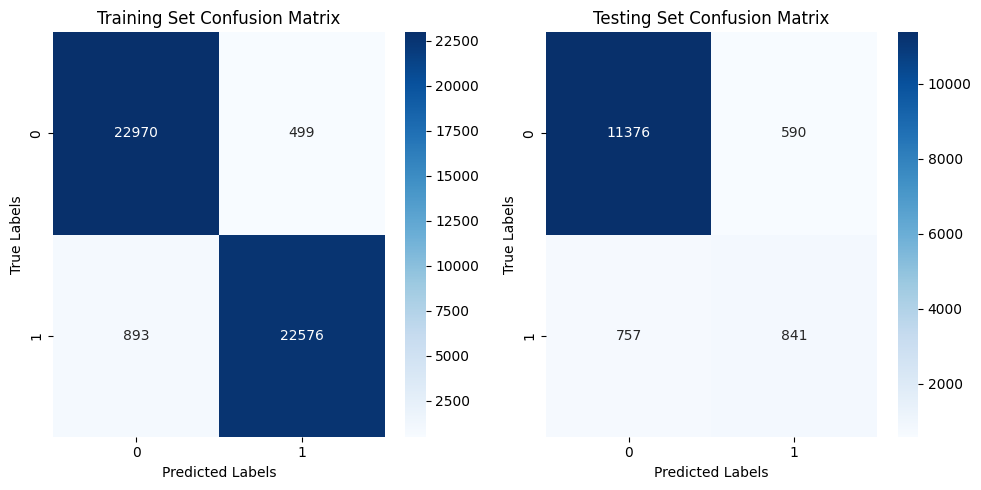

=====Learning_curve XGBoost model..=====


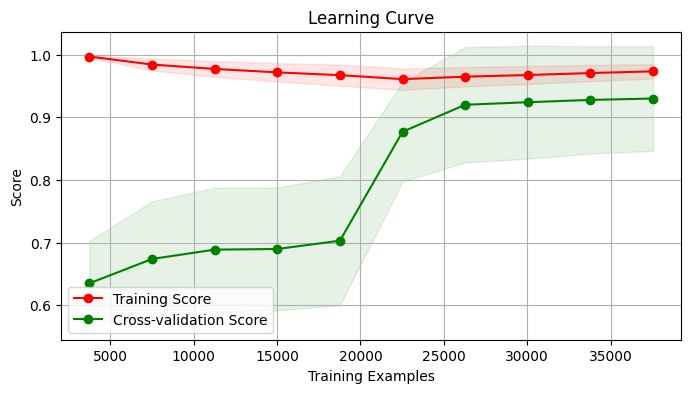

Train Sizes: [ 3755  7510 11265 15020 18775 22530 26285 30040 33795 37550]
Train Scores Mean: [0.99680426 0.9841012  0.97707945 0.97159787 0.96715846 0.96080781
 0.96471752 0.9673968  0.97050451 0.97328362]
Test Scores Mean: [0.6352223  0.67401771 0.68888813 0.68993229 0.70316328 0.87690323
 0.91996018 0.92400808 0.92767239 0.92986674]
=====Plotting ROC curves for all models..=====


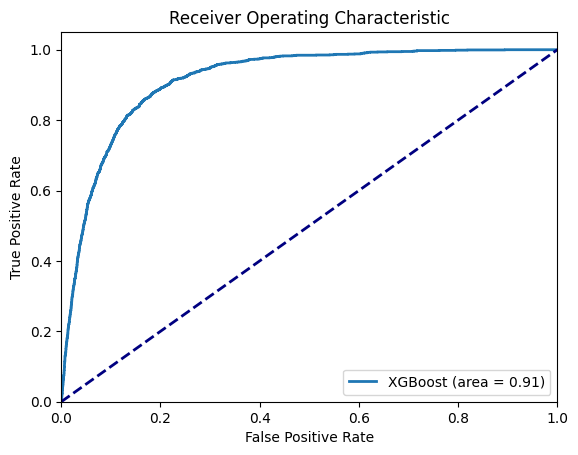

In [ ]:
pipelines = {
    # 'Logistic Regression': Pipeline([
    #     ('classifier', LogisticRegression(random_state=42))
    # ]),
    # 'Decision Tree': Pipeline([
    #     ('classifier', DecisionTreeClassifier(random_state=42))
    # ]),
    # 'Random Forest': Pipeline([
    #     ('classifier', RandomForestClassifier(random_state=42))
    # ]),
    # 'SVM': Pipeline([
    #     ('classifier', SVC(random_state=42))
    # ]),
    # 'KNN': Pipeline([
    #     ('classifier', KNeighborsClassifier())
    # ]),
    'XGBoost': Pipeline([
        ('classifier', XGBClassifier(random_state=42))
    ])
}
for name, pipeline in pipelines.items():
    pipeline.fit(X_resampled, y_resampled)
    # print(f"{name} model trained.")
for name, pipeline in pipelines.items():
    print(f"=====Evaluating {name} model..=====")
    evaluate_model_performance(pipeline, X_resampled, X_test, y_resampled, y_test)
    print(f"=====Learning_curve {name} model..=====")
    plot_learning_curve(pipeline, X_resampled, y_resampled)
    print("="*50)
print(f"=====Plotting ROC curves for all models..=====")
plot_roc_curves(pipelines, X_test, y_test)
print("="*50)